In [2]:
import pandas as pd
import numpy as np

# Load the uploaded Excel file and list the sheet names
excel_path = "Hypothesis 2 data.xlsx"
xls = pd.ExcelFile(excel_path)
sheet_names = xls.sheet_names

sheet_names


['CPI',
 'Interest Rates',
 'GDP',
 'RPPI',
 'New dwellings',
 'disposable income',
 'Morgtage approvals',
 'Population']

In [3]:
import pandas as pd
import numpy as np

# Load Excel file
xls = pd.ExcelFile("Hypothesis 2 data.xlsx")

# ----------------------------------------
# Step 1: Load raw date ranges from each sheet (no cleaning/interpolation yet)
# ----------------------------------------

# RPPI (monthly)
rppi_raw = xls.parse('RPPI')[['Month', 'VALUE']].rename(columns={'Month': 'Date', 'VALUE': 'RPPI'})
rppi_raw['Date'] = pd.to_datetime(rppi_raw['Date'])
rppi_min, rppi_max = rppi_raw['Date'].min(), rppi_raw['Date'].max()

# GDP (quarterly)
gdp_raw = xls.parse('GDP').rename(columns={'observation_date': 'Date'})
gdp_raw['Date'] = pd.to_datetime(gdp_raw['Date'])
gdp_min, gdp_max = gdp_raw['Date'].min(), gdp_raw['Date'].max()

# CPI (monthly)
cpi_raw = xls.parse('CPI')[['Month', 'VALUE']].rename(columns={'Month': 'Date', 'VALUE': 'CPI'})
cpi_raw['Date'] = pd.to_datetime(cpi_raw['Date'])
cpi_min, cpi_max = cpi_raw['Date'].min(), cpi_raw['Date'].max()

# Interest Rates (quarterly)
interest_raw = xls.parse('Interest Rates').rename(columns={'Reporting date': 'Date', 'rates': 'InterestRate'})
interest_raw['Date'] = pd.to_datetime(interest_raw['Date'], dayfirst=True)
interest_min, interest_max = interest_raw['Date'].min(), interest_raw['Date'].max()

# Disposable Income (yearly)
income_raw = xls.parse('disposable income')[['Year', 'VALUE']].rename(columns={'VALUE': 'DisposableIncome'})
income_raw['Date'] = pd.to_datetime(income_raw['Year'].astype(str) + '-01-01')
income_min, income_max = income_raw['Date'].min(), income_raw['Date'].max()

# Mortgage Approvals (monthly)
mortgage_raw = xls.parse('Morgtage approvals')
mortgage_raw.columns = ['Year', 'MonthName', 'MortgageApprovals']
months = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
          'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
mortgage_raw['Month'] = mortgage_raw['MonthName'].map(months)
mortgage_raw['Date'] = pd.to_datetime(mortgage_raw[['Year', 'Month']].assign(DAY=1))
mortgage_min, mortgage_max = mortgage_raw['Date'].min(), mortgage_raw['Date'].max()

# ----------------------------------------
# Step 2: Calculate final common date range
# ----------------------------------------
min_common = max([rppi_min, gdp_min, cpi_min, interest_min, income_min, mortgage_min])
max_common = min([rppi_max, gdp_max, cpi_max, interest_max, income_max, mortgage_max])
print(f"✅ TRUE Common Date Range: {min_common.strftime('%Y-%m')} to {max_common.strftime('%Y-%m')}")

# ----------------------------------------
# Step 3: Re-load & clean/interpolate datasets, then filter using common date range
# ----------------------------------------

# RPPI
rppi = rppi_raw[rppi_raw['Date'].between(min_common, max_common)]

# GDP (quarterly → monthly)
gdp = gdp_raw[gdp_raw['Date'].between(min_common, max_common)]
gdp = gdp.set_index('Date').resample('MS').ffill().reset_index()

# CPI
cpi = cpi_raw[cpi_raw['Date'].between(min_common, max_common)]

# Interest Rate
interest = interest_raw[interest_raw['Date'].between(min_common, max_common)]
interest = interest.set_index('Date').resample('MS').ffill().reset_index()

# Disposable Income
income = income_raw[income_raw['Date'].between(min_common, max_common)]
income = income.set_index('Date').resample('MS').ffill().reset_index()

# Mortgage Approvals
mortgage = mortgage_raw[mortgage_raw['Date'].between(min_common, max_common)]
mortgage = mortgage[['Date', 'MortgageApprovals']]

# ----------------------------------------
# Step 4: Merge & interpolate
# ----------------------------------------
merged_df = rppi.merge(gdp, on='Date', how='left') \
                .merge(cpi, on='Date', how='left') \
                .merge(interest, on='Date', how='left') \
                .merge(income, on='Date', how='left') \
                .merge(mortgage, on='Date', how='left')

merged_df[['GDP', 'CPI', 'InterestRate', 'DisposableIncome', 'MortgageApprovals']] = \
    merged_df[['GDP', 'CPI', 'InterestRate', 'DisposableIncome', 'MortgageApprovals']].interpolate().ffill().bfill()

# ----------------------------------------
# Step 5: Policy One-Hot Encoding
# ----------------------------------------
merged_df['HTB_Active'] = (merged_df['Date'] >= pd.Timestamp('2017-01-01')).astype(int)
merged_df['HTB_Enhanced'] = (merged_df['Date'] >= pd.Timestamp('2020-07-01')).astype(int)
merged_df['RPZ_Active'] = (merged_df['Date'] >= pd.Timestamp('2016-12-01')).astype(int)
merged_df['RPZ_InflationLinked'] = (merged_df['Date'] >= pd.Timestamp('2021-07-01')).astype(int)

# ----------------------------------------
# Step 6: Save Output
# ----------------------------------------
merged_df.to_csv("final_dataset_true_overlap.csv", index=False)
print("📊 Final Shape:", merged_df.shape)
print("✅ Dataset with correct date logic saved as 'final_dataset_true_overlap.csv'")


✅ TRUE Common Date Range: 2014-12 to 2023-12
📊 Final Shape: (108, 12)
✅ Dataset with correct date logic saved as 'final_dataset_true_overlap.csv'


/var/folders/80/dpnwd7h93_s2rmdn2t1q5n0m0000gn/T/ipykernel_1828/2089749585.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  interest_raw['Date'] = pd.to_datetime(interest_raw['Date'], dayfirst=True)


In [29]:
merged_df.head(10)

,Date,RPPI,GDP,CPI,InterestRate,Year,DisposableIncome,MortgageApprovals,HTB_Active,HTB_Enhanced,RPZ_Active,RPZ_InflationLinked
0,2015-01-01,96.5,58221.3,99.1,4.19,2015.0,6.000494e+10,390,0,0,0,0
1,2015-02-01,96.2,60850.2,99.7,4.19,2015.0,6.000494e+10,459,0,0,0,0
2,2015-03-01,96.5,60850.2,100.3,4.19,2015.0,6.000494e+10,455,0,0,0,0
3,2015-04-01,97.3,60850.2,100.3,4.26,2015.0,6.000494e+10,429,0,0,0,0
4,2015-05-01,98.4,60850.2,100.7,4.26,2015.0,6.000494e+10,485,0,0,0,0
5,2015-06-01,100.0,60850.2,100.9,4.26,2015.0,6.000494e+10,495,0,0,0,0
6,2015-07-01,100.8,60850.2,100.7,4.11,2015.0,6.000494e+10,558,0,0,0,0
7,2015-08-01,102.0,60850.2,101.1,4.11,2015.0,6.000494e+10,437,0,0,0,0
8,2015-09-01,102.4,60850.2,100.6,4.11,2015.0,6.000494e+10,474,0,0,0,0
9,2015-10-01,103.5,60850.2,100.4,4.08,2015.0,6.000494e+10,481,0,0,0,0


✅ Shape after lag creation: (96, 18)
Model Performance without Lag Features:
           Model   RMSE    MAE  R² Score
0            OLS   8.22   7.87   -0.1582
1            SVR  26.95  26.03  -11.4591
2  Random Forest  21.09  19.62   -6.6286
3        XGBoost  19.78  18.24   -5.7101

📊 Feature Importance for Random Forest:
            Feature  Importance
       InterestRate    0.911501
                GDP    0.038460
  MortgageApprovals    0.016144
   DisposableIncome    0.012115
         RPZ_Active    0.012006
                CPI    0.008505
         HTB_Active    0.000959
       HTB_Enhanced    0.000310
RPZ_InflationLinked    0.000000

📊 Feature Importance for XGBoost:
            Feature  Importance
       InterestRate    0.984419
  MortgageApprovals    0.006092
                GDP    0.004464
                CPI    0.002602
         RPZ_Active    0.001716
   DisposableIncome    0.000484
       HTB_Enhanced    0.000223
         HTB_Active    0.000000
RPZ_InflationLinked    0.000000


/usr/local/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'plt' is not defined

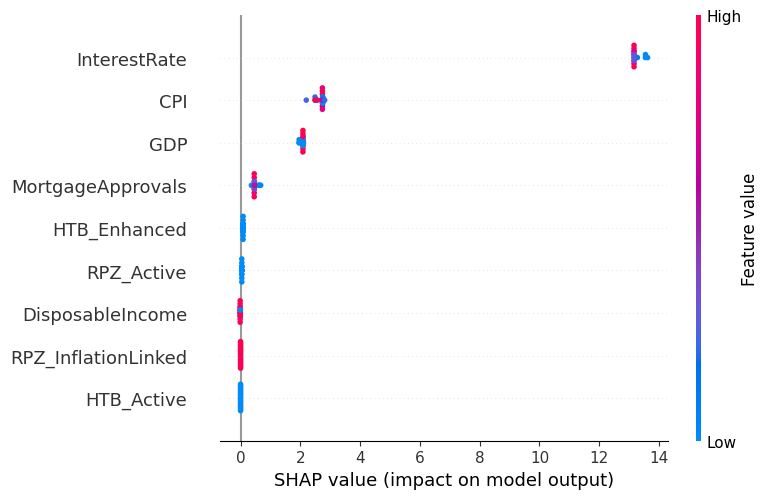

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Copy dataset
df = merged_df.copy()

# --- Step 1: Create Lag Features ---
df['RPPI_lag1'] = df['RPPI'].shift(1)
df['GDP_lag1'] = df['GDP'].shift(1)
df['CPI_lag1'] = df['CPI'].shift(1)
df['InterestRate_lag1'] = df['InterestRate'].shift(1)
df['DisposableIncome_lag1'] = df['DisposableIncome'].shift(1)
df['MortgageApprovals_lag1'] = df['MortgageApprovals'].shift(1)

# --- Step 2: Drop NA caused by shifting ---
df = df.dropna()
print("✅ Shape after lag creation:", df.shape)

# --- Step 3: Define Features & Target ---
X = df[['GDP', 'CPI', 'InterestRate', 'DisposableIncome', 'MortgageApprovals',
        'HTB_Active', 'HTB_Enhanced', 'RPZ_Active', 'RPZ_InflationLinked']]
y = df['RPPI']

# --- Step 4: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# --- Step 5: Initialize Models ---
models = {
    "OLS": LinearRegression(),
    "SVR": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# --- Step 6: Train and Evaluate ---
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R² Score": round(r2, 4)
    })

# --- Step 7: Display Results ---
results_df = pd.DataFrame(results)
print("Model Performance without Lag Features:")
print(results_df)

# --- Step 8: Feature Importance for Tree-based Models ---

feature_names = X.columns

for name, model in models.items():
    if name in ["Random Forest", "XGBoost"]:
        importances = model.feature_importances_
        fi_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        
        print(f"\n📊 Feature Importance for {name}:")
        print(fi_df.to_string(index=False))

import shap

# Explain XGBoost
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# Summary plot (save it)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary for XGBoost")
plt.tight_layout()
plt.savefig("shap_summary_xgb.png", dpi=300)



                            OLS Regression Results                            
Dep. Variable:                   RPPI   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.133e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):          2.56e-128
Time:                        19:02:08   Log-Likelihood:                -77.115
No. Observations:                  96   AIC:                             176.2
Df Residuals:                      85   BIC:                             204.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     13

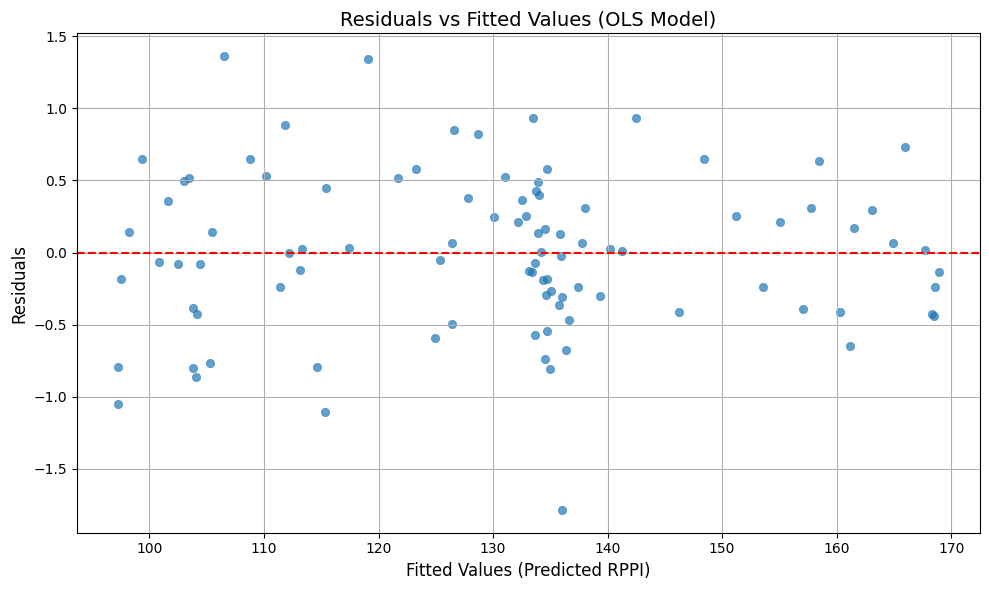

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

# Assuming df is your final dataframe after lagging and cleaning
X = df[['GDP_lag1', 'CPI_lag1', 'InterestRate_lag1', 'DisposableIncome_lag1', 
        'MortgageApprovals_lag1', 'RPPI_lag1', 
        'HTB_Active', 'HTB_Enhanced', 'RPZ_Active', 'RPZ_InflationLinked']]
y = df['RPPI']

# Add constant for statsmodels OLS
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print(ols_model.summary())
# Get fitted values and residuals
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.7, edgecolor=None)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Fitted Values (Predicted RPPI)", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Fitted Values (OLS Model)", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.6/556.6 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 2.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
